### Importing Packages

In [1]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
from collections import Counter
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader
from PIL import Image
import torch.nn.functional as F
import torchvision
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, precision_recall_fscore_support
from torchvision import models
from torchsummary import summary
import warnings  
warnings.filterwarnings("ignore")

In [2]:
config = {
    'images_folder': '/Users/shreyaspatel/Desktop/Concordia University/SEM02/COMP 6721 Applied AI/Project/Part 1/Final_Data/Mask Dataset',
    'train_batch_size': 128,
    'test_batch_size': 128,
    'num_epochs': 20,
    'learning_rate': 0.001
}

savedModel = False
model_path = '/Users/shreyaspatel/Desktop/Concordia University/SEM02/COMP 6721 Applied AI/Project/Part 1/Model'
model_file_name= '/cnn_mask_classification_3_cl_2_pl_new.pt'

In [3]:
def get_images(images_path, test_split=0.20):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Resize([32, 32]),
                                    transforms.Normalize((0.5202, 0.4792, 0.4603), (0.2875, 0.2841, 0.2846))])
    dataset = ImageFolder(images_path, transform=transform)
    classLabels = dataset.class_to_idx;
    classImages = dict(Counter(dataset.targets))

    # Plotting the bar graph of the data
    keys = ["Cloth Mask", "Mask Worn Incorrectly", "N95 Mask", "No Face Mask", "Surgical Mask"]
    values = list(classImages.values())
    plt.bar(keys, values, color ='blue',width = 0.4)
    plt.xlabel("Type of classes")
    plt.ylabel("Number of images")
    plt.title("Number of images in each mask type")
    plt.xticks(rotation = 90)
    plt.show()

    # Showing count of each image
    print("\n")
    for k in keys:
      print(k + ": " + str(classImages[classLabels[k]]))

    train_idx, test_idx = train_test_split(list(range(len(dataset))), test_size=test_split)
    train = Subset(dataset, train_idx)
    test = Subset(dataset, test_idx)

    return train, test

### Splitting Data into Train and Test

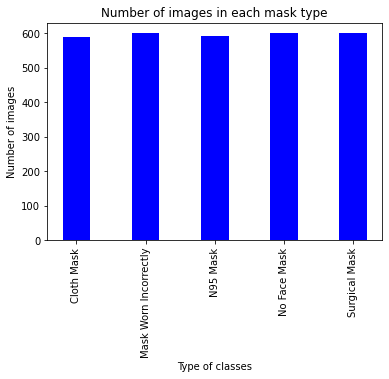



Cloth Mask: 589
Mask Worn Incorrectly: 600
N95 Mask: 593
No Face Mask: 600
Surgical Mask: 600


In [4]:
train_data, test_data = get_images(config['images_folder'])

#### Getting train and test loader

In [5]:
train_dataloader = DataLoader(train_data, batch_size=config["train_batch_size"], shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=config["test_batch_size"], shuffle=False)

### CNN Model

In [6]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv_layer = nn.Sequential(
            
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(inplace=True),
            
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),
            
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            
            #nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            #nn.BatchNorm2d(64),
            #nn.LeakyReLU(inplace=True),
            
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(8 * 8 * 64, 1000),
            nn.ReLU(inplace=True),
            nn.Linear(1000, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 5)
        )

    def forward(self, x):
        # conv layers
        x = self.conv_layer(x)
        # flatten
        x = x.view(x.size(0), -1)
        # fc layer
        x = self.fc_layer(x)
        return x


In [7]:
device = 'cuda' if torch.cuda.is_available() else "cpu"

In [8]:
if savedModel:
  model = Model()
  model.load_state_dict(torch.load(model_path+model_file_name, torch.device(device)))
  model.eval()
  model.to(device)
  summary(model, (3, 32, 32))
else:
  model = Model()
  model = model.to(device)
  summary(model, (3, 32, 32))
  optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])
  criterion = nn.CrossEntropyLoss()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
         LeakyReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           4,640
       BatchNorm2d-5           [-1, 32, 32, 32]              64
         LeakyReLU-6           [-1, 32, 32, 32]               0
         MaxPool2d-7           [-1, 32, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          18,496
       BatchNorm2d-9           [-1, 64, 16, 16]             128
        LeakyReLU-10           [-1, 64, 16, 16]               0
        MaxPool2d-11             [-1, 64, 8, 8]               0
          Dropout-12                 [-1, 4096]               0
           Linear-13                 [-1, 1000]       4,097,000
             ReLU-14                 [-

### Model Training Class 

In [9]:
class ModelTraining:
    def __init__(self, model, device, optimizer, criteria):
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.criteria = criteria

    def training(self, train_dataloader, epochs):
        total_no_of_steps = len(train_dataloader)
        accuracyList = []
        trainingLoss = []
        for epoch in range(epochs):
            self.model.train()
            train_total = 0
            train_correct = 0
            for i, (images, labels) in enumerate(train_dataloader):
                images = images.to(self.device)
                labels = labels.to(self.device)

                outputs = self.model(images)
                loss = self.criteria(outputs, labels)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                _, predicted = torch.max(outputs.data, 1)
                train_total += labels.shape[0]
                train_correct += (predicted == labels).sum().item()
            print(
                f'Epoch {epoch + 1} / {epochs}, Training loss = {loss.item():.4f}, Training accuracy = {(train_correct / train_total) * 100}')
            accuracyList.append((train_correct / train_total) * 100)
            trainingLoss.append(loss.item())
        return accuracyList, trainingLoss

### Training the Model 

In [10]:
if not savedModel:
  model_trainer = ModelTraining(model=model, device=device, optimizer=optimizer, criteria=criterion)
  accuracyList, trainingLossList = model_trainer.training(train_dataloader, epochs=config["num_epochs"])
  torch.save(model.state_dict(),model_path+model_file_name)

Epoch 1 / 20, Training loss = 1.1423, Training accuracy = 35.76519916142558
Epoch 2 / 20, Training loss = 0.9124, Training accuracy = 55.42976939203355
Epoch 3 / 20, Training loss = 0.9017, Training accuracy = 66.33123689727464
Epoch 4 / 20, Training loss = 0.6541, Training accuracy = 70.64989517819707
Epoch 5 / 20, Training loss = 0.4712, Training accuracy = 75.8909853249476
Epoch 6 / 20, Training loss = 0.6745, Training accuracy = 78.74213836477988
Epoch 7 / 20, Training loss = 0.5586, Training accuracy = 84.27672955974843
Epoch 8 / 20, Training loss = 0.4161, Training accuracy = 85.9538784067086
Epoch 9 / 20, Training loss = 0.3163, Training accuracy = 90.39832285115304
Epoch 10 / 20, Training loss = 0.1554, Training accuracy = 92.0754716981132
Epoch 11 / 20, Training loss = 0.1364, Training accuracy = 94.75890985324948
Epoch 12 / 20, Training loss = 0.2603, Training accuracy = 95.63941299790356
Epoch 13 / 20, Training loss = 0.0883, Training accuracy = 96.51991614255765
Epoch 14 / 

#### Plot the graph of training accuracy vs the epoch

Text(0, 0.5, 'Training accuracy')

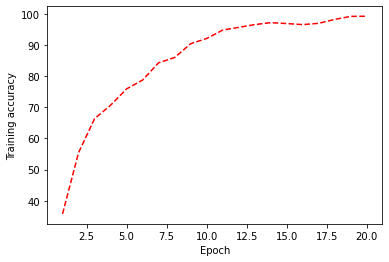

In [11]:
plt.plot(range(1, config['num_epochs']+1), accuracyList, 'r--')
plt.xlabel('Epoch')
plt.ylabel('Training accuracy')

#### Plot the graph of training loss vs the epoch

Text(0, 0.5, 'Training Loss')

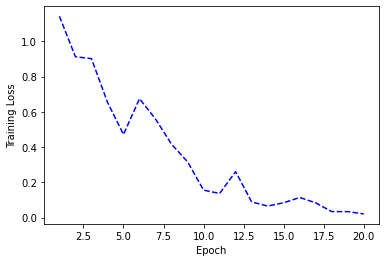

In [12]:
plt.plot(range(1, config['num_epochs']+1), trainingLossList, 'b--')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')

 #### Getting the accuracy of the model

In [13]:
def getModelAccuracy(model, test_dataloader, device):
    model.eval()
    total = 0
    correct = 0
    y_pred = []
    y_true = []
    precision = dict()
    recall = dict()
    avg = dict()
    with torch.no_grad():
        for images, labels in test_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            model_pred_on_test = model(images)
            model_pred_on_test = torch.argmax(F.softmax(model_pred_on_test.data), 1)
            predicted = model_pred_on_test
            total += labels.shape[0]
            correct += (predicted == labels).sum().item()
            if y_pred == []:
              y_true = labels[:]
              y_pred = model_pred_on_test[:]
            else:
              y_true = torch.hstack([y_true, labels])
              y_pred = torch.hstack([y_pred, model_pred_on_test])
        print('Test Accuracy of the model on the test images: {} %'
              .format((correct / total) * 100))
        y_pred = y_pred.cpu().detach().numpy()
        y_true = y_true.cpu().detach().numpy()
        target_names = ["Cloth Mask", "Mask Worn Incorrectly", "N95 Mask", "No Face Mask", "Surgical Mask"]
        labels_names = [0, 1, 2, 3, 4]
        print(classification_report(y_true, y_pred, labels=labels_names, target_names=target_names))
        cm = confusion_matrix(y_true, y_pred, labels=labels_names)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
        disp = disp.plot(cmap=plt.cm.Blues, values_format='g')
        plt.xticks(rotation = 90)
        plt.show()


Test Accuracy of the model on the test images: 76.38190954773869 %
                       precision    recall  f1-score   support

           Cloth Mask       0.77      0.78      0.77       120
Mask Worn Incorrectly       0.85      0.50      0.63       121
             N95 Mask       0.83      0.85      0.84       139
         No Face Mask       0.62      0.90      0.73        96
        Surgical Mask       0.80      0.82      0.81       121

             accuracy                           0.76       597
            macro avg       0.77      0.77      0.76       597
         weighted avg       0.78      0.76      0.76       597



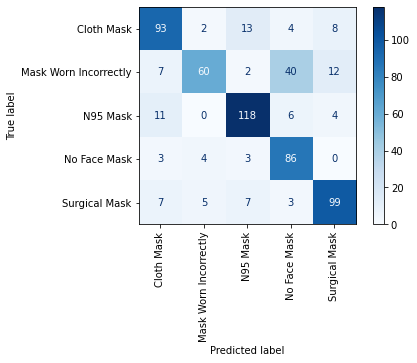

In [14]:
getModelAccuracy(model, test_dataloader, device)

 ### Predicting single image of five classes

#### predict_image class

In [15]:
def predict_image(model, image, device, labels=["Cloth Mask", "Mask Worn Incorrectly", "N95 Mask", "No Face Mask", "Surgical Mask"]):

    model.eval()
    with torch.no_grad():
        image = image.to(device)
        output = model(image.unsqueeze(0))
    pred = output.argmax(dim=1).cpu().numpy()
    return labels[pred[0]]

#### preparing pred data

In [16]:
import glob
import pandas as pd
application_image_directory='/Users/shreyaspatel/Desktop/Concordia University/SEM02/COMP 6721 Applied AI/Project/Part 1/Final_Data/Application Mask Dataset'
labels=["Cloth Mask", "Mask Worn Incorrectly", "N95 Mask", "No Face Mask", "Surgical Mask"]
data_image = []
actual_value  = []
images_path=glob.glob(application_image_directory+'/*.jpeg')
for i in images_path:
    data_image.append(i)
application_image_df = pd.DataFrame(data_image, columns=['Name'])

#### predicting images (application mode)

In [1]:
print('Model Prediction on Application ImageSet')
#plt.title(label =,loc="center", fontsize=29)
plt.rcParams["figure.figsize"] = [15.00, 15.00]
plt.rcParams["figure.autolayout"] = True
fig, ax = plt.subplots(1,5)
for i in range(len(application_image_df)) :
    imageFile = application_image_df.loc[i, "Name"]
    image = Image.open(imageFile)
    
    transform = transforms.Compose(
          [transforms.ToTensor(),
            transforms.Resize((32, 32)),
            transforms.Normalize((0.5202, 0.4792, 0.4603), (0.2875, 0.2841, 0.2846))]
      )
    image = transform(image)
    predicted_mask_class = predict_image(model, image, device)
    
    application_image = plt.imread(imageFile)
    application_image = ax[i].imshow(application_image, extent=[0, 300, 0, 300])
    ax[i].axes.yaxis.set_visible(False)
    ax[i].axes.xaxis.set_ticklabels([])
    ax[i].set_xlabel(predicted_mask_class, fontsize=18)
plt.show()

Model Prediction on Application ImageSet


NameError: name 'plt' is not defined